In [33]:
# !pip install ISLP -q

# PD9: Classification and Regression with Decision Trees

In class, we saw decision trees, which are a Machine Learning method for non-parametric prediction. They rely on partitionning the data into regions by finding thresholds in the features, and datapoints are grouped by their relationship to these thresholds. The value of the thresholds is chosen such that the target values in each region have the least variance (in the case of regression trees) or diversity (in the case of classification trees).

Today we will see how to use them in practice by fitting classification and regression trees.

In [34]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, KFold, cross_validate
from ISLP.models import ModelSpec as MS
from sklearn.datasets import load_iris
from ISLP import load_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Classification: The Iris Dataset

Our running example for classification problems will be the __iris flower dataset__.

This is a classical dataset originally published by [R. A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1936. This is perhaps the best known database to be found in the pattern recognition literature.  Fisher's paper is a classic in the field and is referenced frequently to this day.  (See Duda & Hart, for example.)  The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  One class is linearly separable from the other 2; the latter are NOT linearly separable from each other.

<center><img width=50% src="https://raw.githubusercontent.com/kuleshov/cornell-cs5785-2024-applied-ml/refs/heads/main/slides/img/iris.png"/> <br>
<small style='color: gray;'>Image source: <a href="https://www.datacamp.com/tutorial/machine-learning-in-r">Machine Learning in R for Beginners</a></small></center>

First, we load the dataset (here, it is available through the `datasets` module of the `scikit-learn` package)

In [35]:
X, y = load_iris(return_X_y = True, as_frame = True)

Now, let's see what we mean by the latter two classes not being "linearly separable"

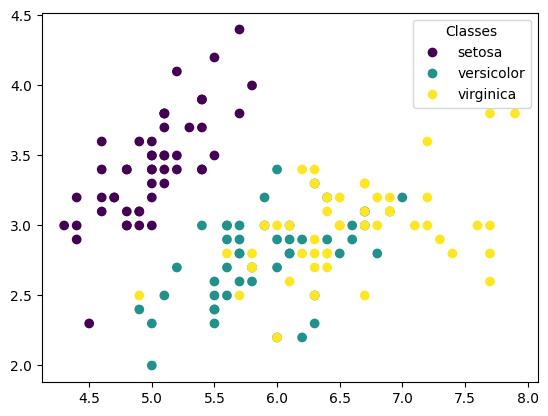

In [36]:
class_names = ["setosa", "versicolor", "virginica"]
_, ax = plt.subplots()
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c = y)
_ = ax.legend(
        scatter.legend_elements()[0], class_names, title = "Classes"
)

It should be fairly easy to classify the setosa species, but the other species may be quite challenging.

Now we split the data into training and testing sets.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .9, random_state = 123)

We now can fit the tree with the training data. We will start with a tree that overfits the data (has a large number of partitions/regions)

In [38]:
tree_model = DecisionTreeClassifier(random_state = 123)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

We can take a look at how our model classifies data by plotting it.

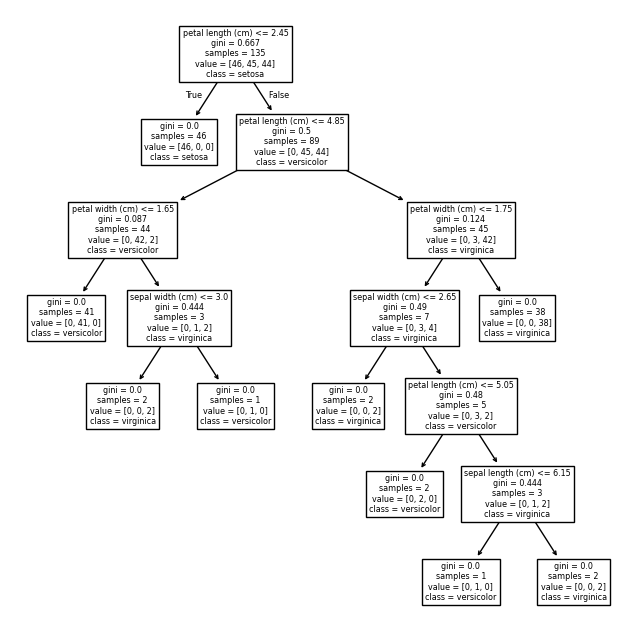

In [39]:
plt.figure(figsize= (8, 8))
_ = plot_tree(tree_model, feature_names = X.columns, class_names = class_names)

We compute the accuracy of the model

In [40]:
predictions = tree_model.predict(X_test)
(predictions == y_test).mean()

0.9333333333333333

This is actually quite a large out-of-sample accuracy. Although we have quite a large tree, it does not seem to overfit the data.

Regardless, we will now prune the tree through the cost-complexity pruning procedure. For the `DecisionTreeClassifier` class from the `sklearn.tree` module, we can specify the $\alpha$ hyperparameter with the `ccp_alpha` option when constructing an instance of the class.

In [41]:
tree_model_prune = DecisionTreeClassifier(ccp_alpha = 0.01, random_state = 123)
tree_model_prune.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01, random_state=123)

This value for $\alpha$ gives us a significantly smaller tree

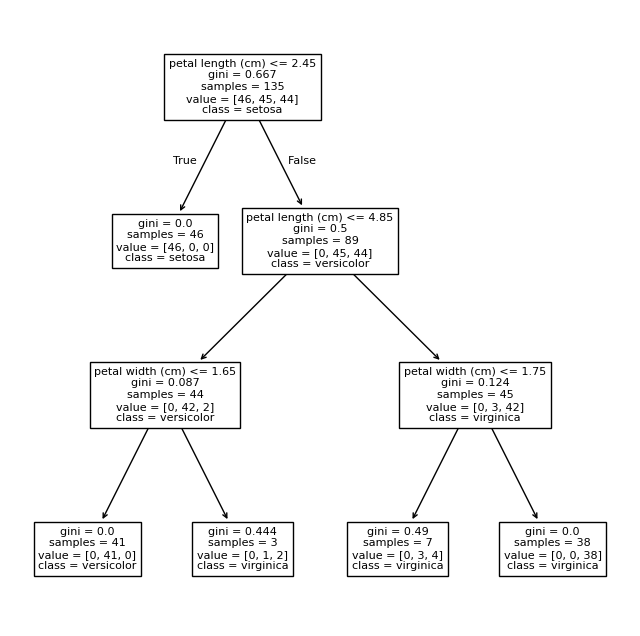

In [42]:
plt.figure(figsize= (8, 8))
_ = plot_tree(tree_model_prune, feature_names = X.columns, class_names = class_names)

We can also see that it has a similar out-of-sample accuracy to the original model, so we are not losing performance from regularization

In [43]:
pruned_predictions = tree_model_prune.predict(X_test)
(pruned_predictions == y_test).mean()

0.9333333333333333

However, we have arbitrarily chosen the value for $\alpha$. We can also choose this value through cross-validation. `scikit-learn`'s `model_selection` module gives us a very useful abstraction for cross-validation, fittingly called `cross_validate`

In [44]:
alphas = np.e ** np.linspace(-10, 0, 100)
folds = KFold(3, shuffle = True, random_state = 123)
inaccuracies = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
        tree = DecisionTreeClassifier(ccp_alpha = alpha, random_state = 123)
        results = cross_validate(tree, X_train, y_train, cv = folds, scoring = "accuracy")
        inaccuracies[i] = 1 - results["test_score"].mean()

Let's plot the cross-validation error for each alpha

Text(0.5, 0, '$\\log\\alpha$')

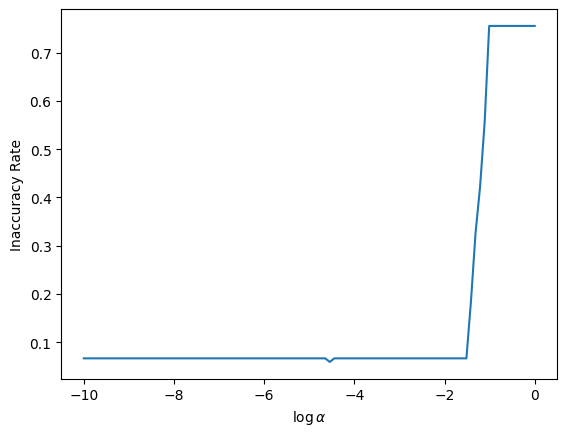

In [45]:
_, ax = plt.subplots()
ax.plot(np.log(alphas), inaccuracies)
ax.set_ylabel("Inaccuracy Rate")
ax.set_xlabel("$\\log\\alpha$")

We must take into account that the $K$-folds procedure gives us an *estimate* of the expected testing error; that is, the error when predicting with never-before-seen data. This estimate will depend on the size of our available sample and how it is split. With a relatively small sample like the one we are working with right now, this estimation may be noisy.

In this case, we will choose the optimal $\alpha$ as the one that minimizes the classification error (conversely, the one that maximizes the accuracy)

In [46]:
optimal_alpha = alphas[np.argmin(inaccuracies)]
optimal_alpha

0.010615346461976675

Now we can take a look at the performance of this model when we use this value for $\alpha$

In [47]:
tree_model_prune = DecisionTreeClassifier(ccp_alpha = optimal_alpha, random_state = 123)
tree_model_prune.fit(X_train, y_train)
pruned_predictions = tree_model_prune.predict(X_test)
(pruned_predictions == y_test).mean()

0.9333333333333333

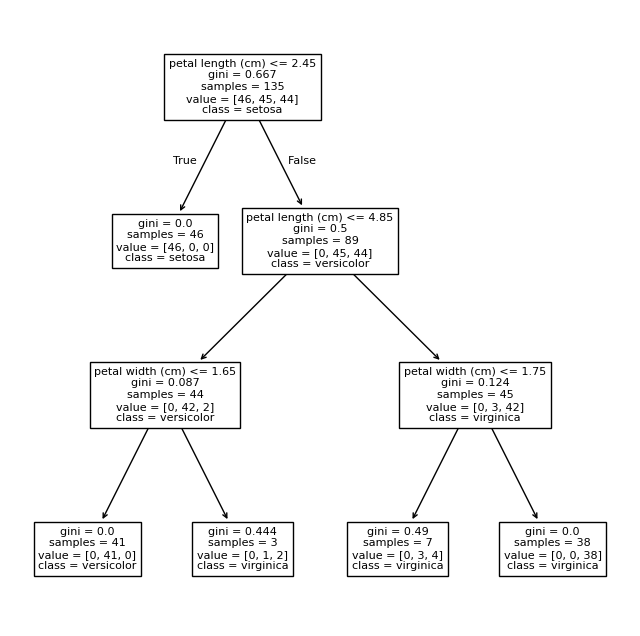

In [48]:
plt.figure(figsize= (8, 8))
_ = plot_tree(tree_model_prune, feature_names = X.columns, class_names = class_names)

## Regression

Now we will see an example more similar to what we have seen in class, because we will be using regression. We will be using the `Hitters` dataset provided by the `ISLP` package through the `load_data` function (this is the package for the book Introduction to Statistical Learning in Python by James, Witten, Hastie, Tibshirani, and Taylor, 2023).

### Baseball Data

Major League Baseball Data from the 1986 and 1987 seasons.

- `AtBat`: Number of times at bat in 1986

- `Hits`: Number of hits in 1986

- `HmRun`: Number of home runs in 1986

- `Runs`: Number of runs in 1986

- `RBI`: Number of runs batted in in 1986

- `Walks`: Number of walks in 1986

- `Years`: Number of years in the major leagues

- `CAtBat`: Number of times at bat during his career

- `CHits`: Number of hits during his career

- `CHmRun`: Number of home runs during his career

- `CRuns`: Number of runs during his career

- `CRBI`: Number of runs batted in during his career

- `CWalks`: Number of walks during his career

- `League`: A factor with levels A and N indicating player’s league at the end of 1986

- `Division`: A factor with levels E and W indicating player’s division at the end of 1986

- `PutOuts`: Number of put outs in 1986

- `Assists`: Number of assists in 1986

- `Errors`: Number of errors in 1986

- `Salary`: 1987 annual salary on opening day in thousands of dollars

- `NewLeague`: A factor with levels A and N indicating player’s league at the beginning of 1987

#### Notes

This dataset was taken from the StatLib library which is maintained at
Carnegie Mellon University. This is part of the data that was
used in the 1988 ASA Graphics Section Poster Session. The salary
data were originally from Sports Illustrated, April 20, 1987. The
1986 and career statistics were obtained from The 1987 Baseball
Encyclopedia Update published by Collier Books, Macmillan
Publishing Company, New York.

In [49]:
Hitters = load_data("Hitters")
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


The data has some missing values, specifically in the `Salary` column. In this instance, we will just drop the missing data, but are several other ways to process missing values.

In [50]:
Hitters["Salary"].isna().sum()

59

In [51]:
Hitters = Hitters.dropna()

We can also use the `ModelSpec` class from the `ILSP.models` to pre-process our data. It makes it quite simple specially to perform one-hot-encoding for categorical data.

In [52]:
model_specification = MS(Hitters.columns.drop("Salary")).fit(Hitters)
X = model_specification.transform(Hitters)
X = X.drop(columns = "intercept")
feature_names = X.columns
X = X.to_numpy()
y = Hitters["Salary"]

In [53]:
pd.DataFrame(X, columns = feature_names).head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
0,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,1.0,1.0,632.0,43.0,10.0,1.0
1,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,0.0,1.0,880.0,82.0,14.0,0.0
2,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,1.0,0.0,200.0,11.0,3.0,1.0
3,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,1.0,0.0,805.0,40.0,4.0,1.0
4,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,0.0,1.0,282.0,421.0,25.0,0.0


Now we split the data as we did before

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, random_state = 123)

And train a tree without limiting parameters, such that we may overfit the training data

In [55]:
tree_model = DecisionTreeRegressor(random_state = 123)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=123)

Now let's plot this tree

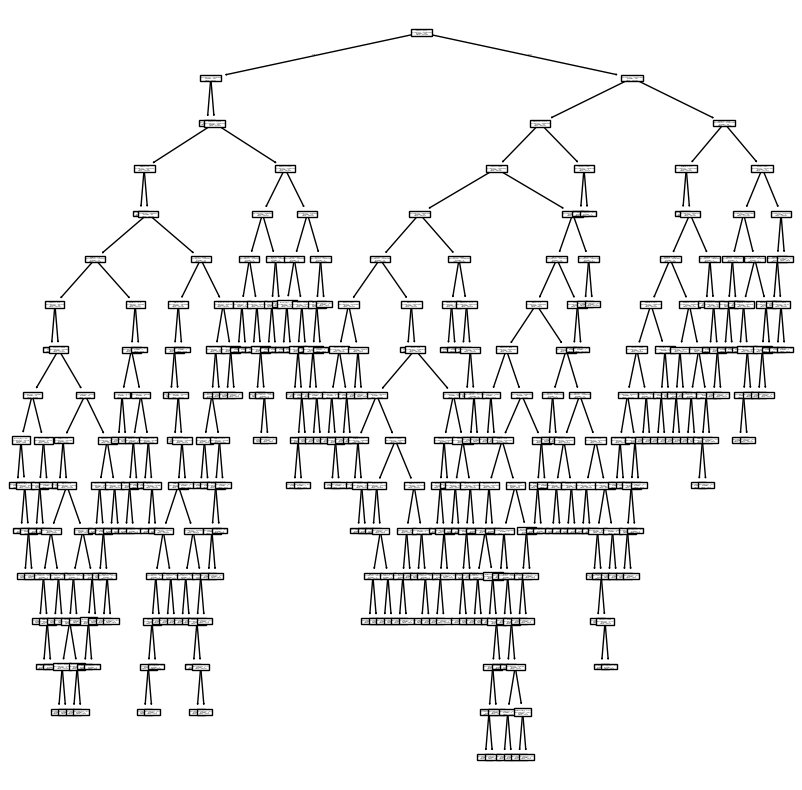

In [56]:
plt.figure(figsize = (10, 10))
_ = plot_tree(tree_model, feature_names = feature_names)

This tree is quite large and has a very large, meaning that it defines a large amount of regions/partitions. We can calculate the Root Mean Square Error of this tree in order to later compare it to a more conservative training procedure.

In [57]:
predictions = tree_model.predict(X_test)
np.sqrt(((y_test - predictions) ** 2).mean())

314.14279406305144

Like before, we can specify the `ccp_alpha` option for the `DecisionTreeRegressor` class

In [58]:
tree_model_prune = DecisionTreeRegressor(random_state = 123, ccp_alpha = 2000)
tree_model_prune.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=2000, random_state=123)

Now we can get a much smaller tree

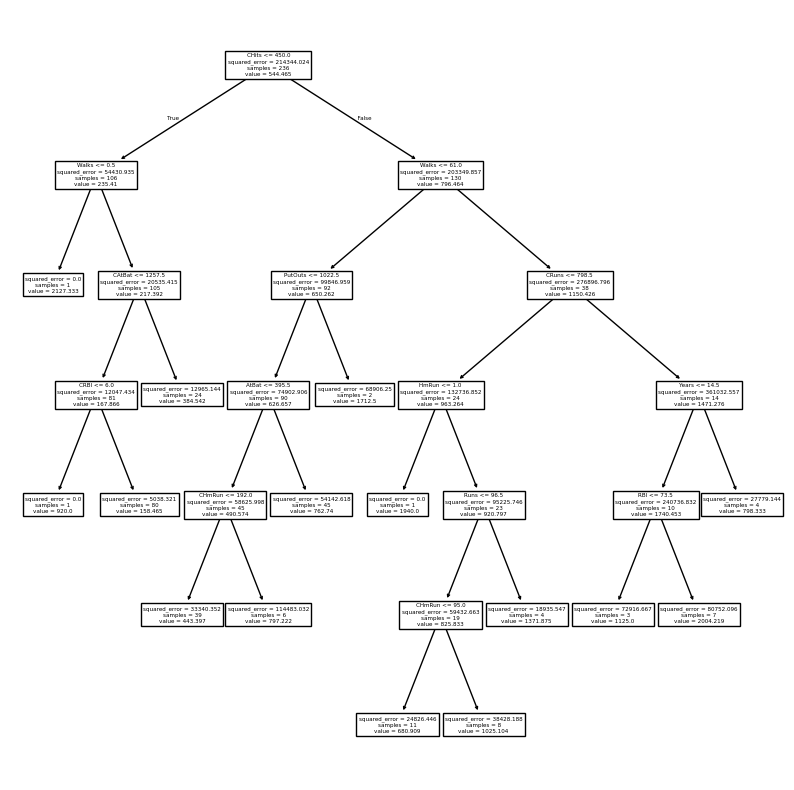

In [59]:
plt.figure(figsize = (10, 10))
_ = plot_tree(tree_model_prune, feature_names = feature_names)

Does it have better performance?

In [60]:
pruned_predictions = tree_model_prune.predict(X_test)
np.sqrt(((y_test - pruned_predictions) ** 2).mean())

262.3246607873066

It does perform better out of sample, meaning that we likely had a problem with overfittin the training data. Now we will follow the same procedure for $K$-folds cross-validation as before. The only difference is that we will use the Root Mean Square Error as our metric.

In [61]:
alphas = np.exp(np.linspace(-2, 10, 100))
folds = KFold(3, shuffle = True, random_state = 123)
rmses = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
        tree = DecisionTreeRegressor(ccp_alpha = alpha, random_state = 123)
        results = cross_validate(tree, X_train, y_train, cv = folds, scoring = "neg_root_mean_squared_error")
        rmses[i] = (- results["test_score"]).mean()

We plot the cross-validation errors against our grid of $\alpha$'s

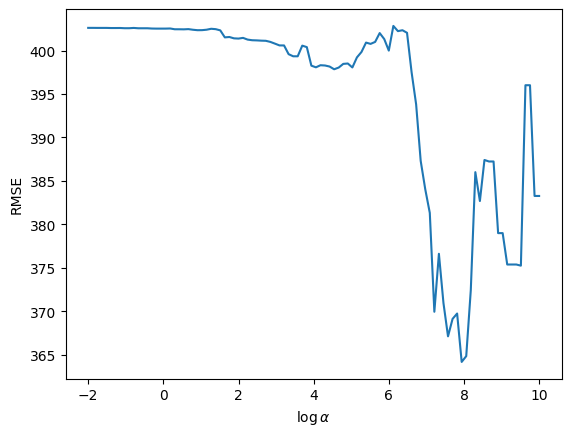

In [62]:
_, ax = plt.subplots()
ax.plot(np.log(alphas), rmses)
ax.set_xlabel("$\\log\\alpha$")
ax.set_ylabel("RMSE")
plt.show()

What is the optimal $\alpha$ in this scenario?

In [63]:
optimal_alpha = alphas[np.argmin(rmses)]
optimal_alpha

2805.6595931703937

Let's now see if it gives us better performance than before. The same caveats for cross-validation as before apply here

In [64]:
tree_model_prune = DecisionTreeRegressor(ccp_alpha = optimal_alpha, random_state = 123)
tree_model_prune.fit(X_train, y_train)
pruned_predictions = tree_model_prune.predict(X_test)
np.sqrt(((y_test - pruned_predictions) ** 2).mean())

264.9303766332589

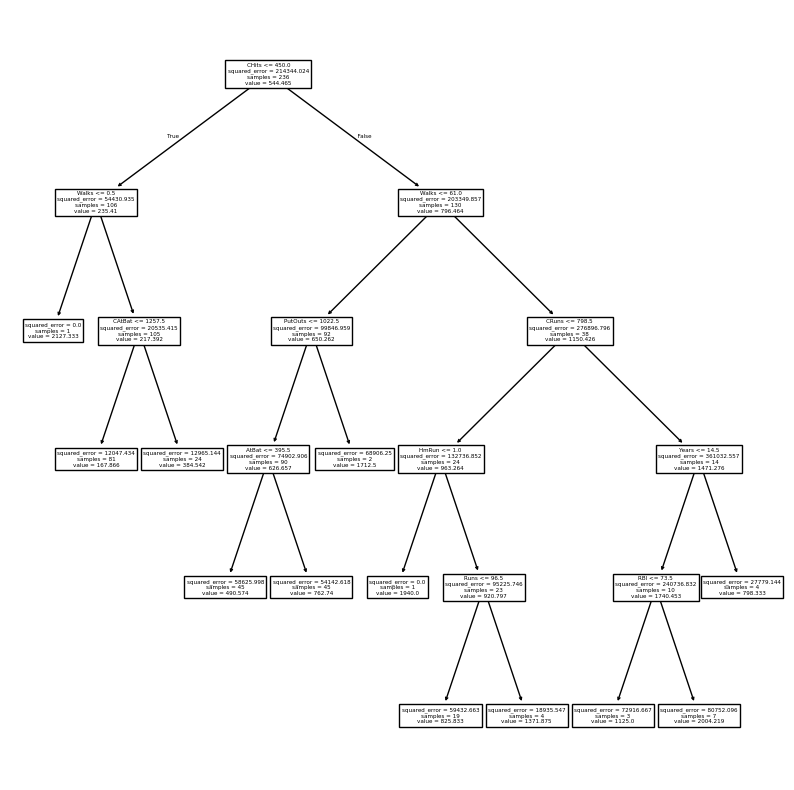

In [65]:
plt.figure(figsize = (10, 10))
_ = plot_tree(tree_model_prune, feature_names = feature_names)